In [1]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

from waymo_open_dataset.utils import range_image_utils
from waymo_open_dataset.utils import transform_utils
from waymo_open_dataset.utils import  frame_utils
from waymo_open_dataset import dataset_pb2 as open_dataset
from waymo_open_dataset.protos import scenario_pb2

import os

import warnings
import json
from tqdm.auto import tqdm

from pykalman import KalmanFilter, AdditiveUnscentedKalmanFilter
%load_ext tensorboard

import pandas as pd

warnings.filterwarnings('ignore')

tfd = tfp.distributions
tfb = tfp.bijectors

dtype = tf.float32

np.random.seed(7)

In [2]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
tfp.__version__

'0.16.0'

In [4]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        if isinstance(obj, np.float32):
            return float(obj)
        if isinstance(obj, np.int16):
            return int(obj)
        if isinstance(obj, np.int64):
            return int(obj)
        if isinstance(obj, tf.Tensor):
            return float(obj)
        return json.JSONEncoder.default(self, obj)

# Transform Data to Numpy Array (3 hours)

In [7]:
FILENAME = "data/training/"
path_list = [] # lists all tfrecord files inside training_20s

for root, dirs, files in os.walk(os.path.abspath(FILENAME)):
    files.sort()
    for file in files:
        path_list.append(os.path.join(root, file))

# function to unpack the recorded data
def process_Data(filename): 
    i_ego, i_agt = 0, 0

    dataset = tf.data.TFRecordDataset(filename)
    
    data_all = []
    
    for data in dataset:
        ego_sub_data = {'filename': os.path.split(filename)[-1], 'scenario_id': None, 'timestamp': None, 'ego_traj': None}
        
        proto_string = data.numpy()
        proto = scenario_pb2.Scenario()
        proto.ParseFromString(proto_string)        

        ego_traj = np.array([[state.center_x, state.center_y,state.center_z, state.heading, state.velocity_x, state.velocity_y]for state in proto.tracks[proto.sdc_track_index].states]).astype(np.float32)
        
        ego_sub_data['scenario_id'] = proto.scenario_id
        ego_sub_data['timestamp'] = np.array(proto.timestamps_seconds).astype(np.float32)
        ego_sub_data['ego_traj'] = ego_traj

        
        with open('data/ego_trajs_json/'+ os.path.split(filename)[-1]+ '_' + str(i_ego).zfill(5)+ '.json', "w") as write_file:
            json.dump(ego_sub_data, write_file, cls=NumpyEncoder)
        
        i_ego = i_ego + 1
        
        for track in proto.tracks_to_predict:
            if proto.tracks[track.track_index].object_type == 1 and track.track_index != proto.sdc_track_index: # Vechicle
                agt_sub_data = {'filename': os.path.split(filename)[-1], 'scenario_id': proto.scenario_id, 'timestamp': None, 'ego_traj': ego_traj, 'agt_traj': None}
                agt_traj = np.array([[state.center_x, state.center_y,state.center_z, state.heading, state.velocity_x, state.velocity_y] for state in proto.tracks[track.track_index].states]).astype(np.float32)
               
                agt_sub_data['timestamp'] = np.array(proto.timestamps_seconds).astype(np.float32)
                agt_sub_data['agt_traj'] = agt_traj
                
                with open('data/agt_trajs_json_new/'+ os.path.split(filename)[-1]+ '_' + str(i_ego).zfill(5) + '_' + str(i_agt).zfill(5)+ '.json', "w") as write_file:
                    json.dump(agt_sub_data, write_file, cls=NumpyEncoder)
                i_agt = i_agt+1
            
    return  None


for k in tqdm(path_list):
    process_Data(k) 
    
print('finish')

  0%|          | 0/1000 [00:00<?, ?it/s]

finish


# Preprocessing Ego Trajectories (Smoothing)

In [6]:
def extract_ego_data(file_path, origin_num_of_points, target_num_of_points):
    assert origin_num_of_points >= target_num_of_points
    
    with open(file_path, "r") as read_file:
         data = json.load(read_file)
    
    start_point_idx = np.random.randint(origin_num_of_points-target_num_of_points +1)
    end_point_idx = start_point_idx + target_num_of_points
    
    T = np.array(data['timestamp'])[start_point_idx:end_point_idx] - np.array(data['timestamp'])[start_point_idx] # Let timestamp start from zero

    traj_xy = np.array(data['ego_traj'])[start_point_idx:end_point_idx, :2] - np.array(data['ego_traj'])[start_point_idx, :2] # Let trajectory start from zero
    #traj_heading = np.array(data['ego_traj'])[:, 3]
    #traj_v = np.linalg.norm(np.array(data['ego_traj'])[:, [4,5]], axis = 1)
    traj_v = np.array(data['ego_traj'])[start_point_idx:end_point_idx, [4,5]]
    #traj = np.concatenate((traj_xy, traj_heading[:, None], traj_v[:, None]), axis = 1)
    traj = np.concatenate((traj_xy, traj_v), axis = 1)
    return T, traj, start_point_idx

In [7]:
path_list = []
origin_num_points_in_traj = 91 # Number of points in trajectories without splitting
num_points_in_traj = 81 # Target Number of points after splitting
for root, dirs, files in os.walk(os.path.abspath('data/ego_trajs_json/')):
    files.sort()
    for file in files:
        path_list.append(os.path.join(root, file))


In [8]:
num_points_in_trajs = [31, 21, 11]
for num_points_in_traj in num_points_in_trajs:
    print(num_points_in_traj)
    np.random.seed(7)
    posterior_means = np.zeros((len(path_list), num_points_in_traj, 6))
    posterior_a_lon = np.zeros((len(path_list), num_points_in_traj))

    outlier_idx_acc = []
    outlier_idx_time = []
    outlier_idx_pos = []
    outlier_idx = []
    start_point_indicies = []

    R = np.diag([0.01, 0.01, 0.1, 0.1]) # Observation Cov
    initial_state_mean = np.zeros(6)
    initial_state_covariance = np.diag(np.array([0.01, 0.1, 10, 0.01, 0.1, 10]))

    dt = 0.1

    observation_matrix = np.array([[1, 0, 0, 0, 0, 0],
                                   [0, 0, 0, 1, 0, 0],
                                   [0, 1, 0, 0, 0, 0],
                                   [0, 0, 0, 0, 1, 0]])

    Q = np.kron(np.eye(2), np.array([[(dt**5)/20, (dt**4)/8, (dt**3)/6],
                          [(dt**4)/8,  (dt**3)/3, (dt**2)/2],
                          [(dt**3)/6,  (dt**2)/2, dt]]).astype(np.float32)) # Process Cov

    #for test_id in test_list:
    for idx, path in enumerate(tqdm(path_list)):
        T, traj, start_point_idx = extract_ego_data(path, origin_num_points_in_traj, num_points_in_traj)
        start_point_indicies.append(start_point_idx)

        dT = T[1:] - T[:-1]

        transition_matrices = [np.kron(np.eye(2), np.array([[1, dt, 0.5* (dt**2)], 
                                                             [0, 1, dt],
                                                             [0, 0, 1]])) for dt in dT]

        initial_state_mean[1] = traj[0,2]
        initial_state_mean[4] = traj[0,3]


        kf = KalmanFilter(transition_matrices = transition_matrices, observation_matrices = observation_matrix, transition_covariance = Q,
                      observation_covariance = R, initial_state_mean = initial_state_mean, initial_state_covariance = initial_state_covariance)

        smoothed_state_means, smoothed_state_covariances  = kf.smooth(traj)

        v_xy = smoothed_state_means[:, [1, 4]]
        a_xy = smoothed_state_means[:, [2, 5]]

        a_lon = np.array([np.dot(a ,v) / np.linalg.norm(v) for a, v in zip(a_xy.reshape(-1,2), v_xy.reshape(-1,2))])

        a_lon = a_lon.reshape(-1, num_points_in_traj)

        posterior_means[idx] = smoothed_state_means
        posterior_a_lon[idx] = a_lon

        delta_pos_max = np.amax(np.linalg.norm(traj[:,[0,1]] - smoothed_state_means[:, [0,3]], axis=1))

        if delta_pos_max >2:
            outlier_idx_pos.append(idx)

        if (T[-1] >= ((num_points_in_traj-1) / 10) +0.5 ) | (T[-1] < ((num_points_in_traj-1) / 10) -0.5):
            outlier_idx_time.append(idx)

        outlier_points_acc = np.argwhere((a_lon > 6) |(a_lon < -9.8))
        if outlier_points_acc.shape[0] > 0:
            outlier_idx_acc.append(idx)

    outlier_idx = set(outlier_idx_acc) | set(outlier_idx_time) | set(outlier_idx_pos)
    print(len(outlier_idx), len(outlier_idx_acc), len(outlier_idx_time), len(outlier_idx_pos))

    PATH = "data/ego_trajs_" + str(num_points_in_traj) + "_json"
    if not os.path.exists(PATH):
        os.makedirs(PATH)

    with open(PATH + "/ego_trajs_outlier_indicies.json", "w") as write_file:
        json.dump(list(outlier_idx), write_file, cls=NumpyEncoder)

    with open(PATH + "/ego_trajs_outlier_indicies_pos.json", "w") as write_file:
        json.dump(list(outlier_idx_pos), write_file, cls=NumpyEncoder)

    with open(PATH + "/ego_trajs_outlier_indicies_acc.json", "w") as write_file:
        json.dump(outlier_idx_acc, write_file, cls=NumpyEncoder)

    with open(PATH + "/ego_trajs_outlier_indicies_time.json", "w") as write_file:
        json.dump(outlier_idx_time, write_file, cls=NumpyEncoder)

    with open(PATH + "/ego_trajs_start_point_indicies.json", "w") as write_file:
        json.dump(start_point_indicies, write_file, cls=NumpyEncoder)

    with open(PATH + "/ego_trajs_filtered_CA.json", "w") as write_file:
        json.dump(posterior_means, write_file, cls=NumpyEncoder)

    with open(PATH + "/ego_trajs_filtered_a_lon.json", "w") as write_file:
        json.dump(posterior_a_lon, write_file, cls=NumpyEncoder)

31


  0%|          | 0/487002 [00:00<?, ?it/s]

20 0 20 0
21


  0%|          | 0/487002 [00:00<?, ?it/s]

10 0 10 0
11


  0%|          | 0/487002 [00:00<?, ?it/s]

7 1 6 0


In [6]:
with open("data/ego_trajs_91_json/ego_trajs_start_point_indicies.json", "w") as write_file:
    json.dump(start_indicies_91.tolist(), write_file, cls=NumpyEncoder)

In [10]:
import os

PATH = "data/ego_trajs_" + str(num_points_in_traj) + "_json"
if not os.path.exists(PATH):
    os.makedirs(PATH)
    
with open(PATH + "/ego_trajs_outlier_indicies.json", "w") as write_file:
    json.dump(list(outlier_idx), write_file, cls=NumpyEncoder)

with open(PATH + "/ego_trajs_outlier_indicies_pos.json", "w") as write_file:
    json.dump(list(outlier_idx_pos), write_file, cls=NumpyEncoder)

with open(PATH + "/ego_trajs_outlier_indicies_acc.json", "w") as write_file:
    json.dump(outlier_idx_acc, write_file, cls=NumpyEncoder)

with open(PATH + "/ego_trajs_outlier_indicies_time.json", "w") as write_file:
    json.dump(outlier_idx_time, write_file, cls=NumpyEncoder)
    
with open(PATH + "/ego_trajs_start_point_indicies.json", "w") as write_file:
    json.dump(start_point_indicies, write_file, cls=NumpyEncoder)

In [9]:
with open(PATH + "/ego_trajs_filtered_CA.json", "w") as write_file:
    json.dump(posterior_means, write_file, cls=NumpyEncoder)

with open(PATH + "/ego_trajs_filtered_a_lon.json", "w") as write_file:
    json.dump(posterior_a_lon, write_file, cls=NumpyEncoder)

In [ ]:
idx = 406247
fig, ax = plt.subplots()
test_t, test_traj = extract_ego_data(path_list[idx])
ax.plot(test_traj[:,0], test_traj[:,1], 'o', label = 'Measurement')
ax.plot(posterior_means[idx,:, 0], posterior_means[idx,:,3], 'o', fillstyle = 'none', label = 'KS Fitting')
ax.legend()
#fig.savefig('Outlier Ego Traj Example.svg', dpi = 300)

# Find not moving ego trajectories

In [5]:
path_list = []
num_points_in_traj = 91
for root, dirs, files in os.walk(os.path.abspath('data/ego_trajs_json/')):
    files.sort()
    for file in files:
        path_list.append(os.path.join(root, file))

In [6]:
def extract_data(file_path):
    with open(file_path, "r") as read_file:
         data = json.load(read_file) 

    traj_xy = np.array(data['ego_traj'])[:, :2] - np.array(data['ego_traj'])[0, :2] # Let trajectory start from zero

    return traj_xy

In [11]:
not_moving_list = []
for idx, path in enumerate(tqdm(path_list)):
    traj = extract_data(path)
    
    d = np.linalg.norm(traj[-1])
    if d <= 0.5:
        not_moving_list.append(idx)
        
len(not_moving_list)

  0%|          | 0/487002 [00:00<?, ?it/s]

In [14]:
with open("data/ego_trajs_not_moving_indicies.json", "w") as write_file:
    json.dump(not_moving_list, write_file, cls=NumpyEncoder)

# Preprocessing Agent Trajectories (Smoothing, 6 hours)

In [5]:
def extract_agt_data(file_path, origin_num_of_points, target_num_of_points):
    assert origin_num_of_points >= target_num_of_points
    
    with open(file_path, "r") as read_file:
         data = json.load(read_file)
    
    start_point_idx = np.random.randint(origin_num_of_points-target_num_of_points +1)
    end_point_idx = start_point_idx + target_num_of_points
    
    T = np.array(data['timestamp'])[start_point_idx:end_point_idx] - np.array(data['timestamp'])[start_point_idx] # Let timestamp start from zero

    traj_xy = np.array(data['agt_traj'])[start_point_idx:end_point_idx, :2] - np.array(data['agt_traj'])[start_point_idx, :2] # Let trajectory start from zero
    
    traj_v = np.array(data['agt_traj'])[start_point_idx:end_point_idx, [4,5]]
    
    traj = np.concatenate((traj_xy, traj_v), axis = 1)
    return T, traj, start_point_idx

In [7]:
agt_file_path_list = []
np.random.seed(7)

select_file_idx = np.sort(np.random.choice(range(1829161), size=600000, replace=False)) # We have totally 1883581 agent trajectories
origin_num_points_in_traj = 91 # Number of points in trajectories without splitting
num_points_in_traj = 91 # Target Number of points after splitting
for root, dirs, files in os.walk(os.path.abspath('data/agt_trajs_json/')):
    files.sort()
    for idx, file in enumerate(tqdm(files)):
        if idx in select_file_idx:
            agt_file_path_list.append(os.path.join(root, file))
        


  0%|          | 0/1829161 [00:00<?, ?it/s]

In [ ]:
num_points_in_trajs = [91, 81, 71, 61, 51, 41, 31, 21, 11]
for num_points_in_traj in num_points_in_trajs:
    print(num_points_in_traj)
    np.random.seed(7)
    posterior_means = np.zeros((len(agt_file_path_list), num_points_in_traj, 6))
    posterior_a_lon = np.zeros((len(agt_file_path_list), num_points_in_traj))

    outlier_idx_acc = []
    outlier_idx_time = []
    outlier_idx_pos = []
    outlier_idx_not_moving = []
    outlier_idx = []
    start_point_indicies = []

    R = np.diag([0.1, 0.1, 0.5, 0.5]) # Agt Observation Cov
    #R = np.diag([0.01, 0.01, 0.1, 0.1]) # Ego Observation Cov
    initial_state_mean = np.zeros(6)
    initial_state_covariance = np.diag(np.array([0.1, 0.5, 10, 0.1, 0.5, 10]))

    dt = 0.1

    observation_matrix = np.array([[1, 0, 0, 0, 0, 0],
                                   [0, 0, 0, 1, 0, 0],
                                   [0, 1, 0, 0, 0, 0],
                                   [0, 0, 0, 0, 1, 0]])

    Q = np.kron(np.eye(2), np.array([[(dt**5)/20, (dt**4)/8, (dt**3)/6],
                          [(dt**4)/8,  (dt**3)/3, (dt**2)/2],
                          [(dt**3)/6,  (dt**2)/2, dt]]).astype(np.float32)) # Process Cov

    #for test_id in test_list:
    for idx, path in enumerate(tqdm(agt_file_path_list)):
        T, traj, start_point_idx = extract_agt_data(path, origin_num_points_in_traj, num_points_in_traj)
        start_point_indicies.append(start_point_idx)

        dT = T[1:] - T[:-1]

        transition_matrices = [np.kron(np.eye(2), np.array([[1, dt, 0.5* (dt**2)], 
                                                             [0, 1, dt],
                                                             [0, 0, 1]])) for dt in dT]

        initial_state_mean[1] = traj[0,2]
        initial_state_mean[4] = traj[0,3]


        kf = KalmanFilter(transition_matrices = transition_matrices, observation_matrices = observation_matrix, transition_covariance = Q,
                      observation_covariance = R, initial_state_mean = initial_state_mean, initial_state_covariance = initial_state_covariance)

        smoothed_state_means, smoothed_state_covariances  = kf.smooth(traj)

        v_xy = smoothed_state_means[:, [1, 4]]
        a_xy = smoothed_state_means[:, [2, 5]]

        a_lon = np.array([np.dot(a ,v) / np.linalg.norm(v) for a, v in zip(a_xy.reshape(-1,2), v_xy.reshape(-1,2))])

        a_lon = a_lon.reshape(-1, num_points_in_traj)

        posterior_means[idx] = smoothed_state_means
        posterior_a_lon[idx] = a_lon

        delta_pos_max = np.amax(np.linalg.norm(traj[:,[0,1]] - smoothed_state_means[:, [0,3]], axis=1))
        
        moving_d = np.linalg.norm(traj[-1, :2])
        
        if delta_pos_max >2:
            outlier_idx_pos.append(idx)
            
        if moving_d <= 0.5:
            outlier_idx_not_moving.append(idx)

        if (T[-1] >= ((num_points_in_traj-1) / 10) +0.5 ) | (T[-1] < ((num_points_in_traj-1) / 10) -0.5):
            outlier_idx_time.append(idx)

        outlier_points_acc = np.argwhere((a_lon > 6) |(a_lon < -9.8))
        if outlier_points_acc.shape[0] > 0:
            outlier_idx_acc.append(idx)

    outlier_idx = set(outlier_idx_acc) | set(outlier_idx_time) | set(outlier_idx_pos) | set(outlier_idx_not_moving)
    
    non_outlier_idx = list(set(range(idx+1)) - outlier_idx)
    non_outlier_idx = np.sort(np.random.choice(non_outlier_idx, size=300000, replace=False))
    

    print('Find {0} outliers, from which {1} acc outlier, {2} time outlier, {3} pos outlier, {4} not moving'.format(len(outlier_idx), len(outlier_idx_acc), len(outlier_idx_time), len(outlier_idx_pos),len(outlier_idx_not_moving)))

    PATH = "data/agt_trajs_" + str(num_points_in_traj) + "_json"
    if not os.path.exists(PATH):
        os.makedirs(PATH)

    with open(PATH + "/agt_trajs_outlier_indicies.json", "w") as write_file:
        json.dump(list(outlier_idx), write_file, cls=NumpyEncoder)

    with open(PATH + "/agt_trajs_outlier_indicies_pos.json", "w") as write_file:
        json.dump(list(outlier_idx_pos), write_file, cls=NumpyEncoder)

    with open(PATH + "/agt_trajs_outlier_indicies_acc.json", "w") as write_file:
        json.dump(outlier_idx_acc, write_file, cls=NumpyEncoder)

    with open(PATH + "/agt_trajs_outlier_indicies_time.json", "w") as write_file:
        json.dump(outlier_idx_time, write_file, cls=NumpyEncoder)
        
    with open(PATH + "/agt_trajs_outlier_indicies_not_moving.json", "w") as write_file:
        json.dump(outlier_idx_not_moving, write_file, cls=NumpyEncoder)
    
    with open(PATH + "/agt_trajs_select_non_outlier_indicies.json", "w") as write_file:
        json.dump(select_file_idx[non_outlier_idx], write_file, cls=NumpyEncoder)
    
    with open(PATH + "/agt_trajs_start_point_indicies.json", "w") as write_file:
        json.dump(np.array(start_point_indicies)[non_outlier_idx], write_file, cls=NumpyEncoder)

    with open(PATH + "/agt_trajs_filtered_CA.json", "w") as write_file:
        json.dump(posterior_means[non_outlier_idx], write_file, cls=NumpyEncoder)

    with open(PATH + "/agt_trajs_filtered_a_lon.json", "w") as write_file:
        json.dump(posterior_a_lon[non_outlier_idx], write_file, cls=NumpyEncoder)

91


  0%|          | 0/600000 [00:00<?, ?it/s]

Find 221778 outliers, from which 220823 acc outlier, 303 time outlier, 220489 pos outlier, 15376 not moving
81


  0%|          | 0/600000 [00:00<?, ?it/s]

Find 186774 outliers, from which 185592 acc outlier, 238 time outlier, 185576 pos outlier, 4805 not moving
71


  0%|          | 0/600000 [00:00<?, ?it/s]

In [9]:
list(outlier_idx)[:100]

[262145,
 2,
 5,
 262153,
 11,
 524299,
 524303,
 262162,
 262163,
 524307,
 524310,
 524312,
 524313,
 524319,
 262176,
 33,
 262178,
 262180,
 262181,
 524326,
 39,
 524328,
 262187,
 524334,
 47,
 49,
 262194,
 51,
 524337,
 262197,
 524340,
 262200,
 60,
 61,
 262209,
 262210,
 67,
 524355,
 262215,
 262218,
 524366,
 262226,
 524375,
 88,
 262234,
 91,
 524382,
 96,
 262241,
 524386,
 524387,
 524399,
 111,
 262257,
 524400,
 115,
 524403,
 524407,
 123,
 524411,
 262269,
 262270,
 127,
 524412,
 262273,
 130,
 134,
 262281,
 140,
 141,
 262284,
 524431,
 148,
 151,
 262296,
 524440,
 524443,
 262299,
 262302,
 524446,
 524450,
 262306,
 163,
 262310,
 524456,
 168,
 524457,
 172,
 173,
 524461,
 174,
 524464,
 262322,
 262323,
 185,
 262330,
 524478,
 193,
 262339,
 262340]

In [22]:
outlier_idx

{3,
 7,
 8,
 11,
 13,
 17,
 19,
 20,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 31,
 32,
 33,
 34,
 41,
 42,
 43,
 47,
 49,
 51,
 59,
 60,
 62,
 65,
 75,
 76,
 77,
 78,
 89,
 98,
 99,
 100,
 101,
 104,
 107,
 108,
 111,
 113,
 117,
 118,
 119,
 120,
 124,
 128,
 130,
 134,
 145,
 146,
 147,
 149,
 153,
 155,
 161,
 170,
 171,
 173,
 175,
 178,
 181,
 182,
 185,
 188,
 191,
 195,
 198,
 200,
 201,
 202,
 203,
 204,
 205,
 207,
 210,
 212,
 214,
 217,
 218,
 220,
 221,
 222,
 225,
 235,
 236,
 240,
 241,
 249,
 253,
 255,
 257,
 258,
 261,
 262,
 263,
 264,
 266,
 268,
 269,
 277,
 283,
 289,
 290,
 291,
 298,
 299,
 305,
 306,
 311,
 314,
 316,
 318,
 321,
 336,
 338,
 344,
 352,
 357,
 362,
 364,
 365,
 366,
 368,
 375,
 377,
 382,
 384,
 385,
 386,
 388,
 389,
 390,
 392,
 393,
 394,
 395,
 399,
 401,
 409,
 411,
 412,
 415,
 416,
 417,
 418,
 420,
 421,
 422,
 429,
 430,
 431,
 433,
 434,
 442,
 443,
 446,
 449,
 450,
 453,
 457,
 459,
 462,
 463,
 468,
 469,
 476,
 487,
 492,
 494,
 496,
 

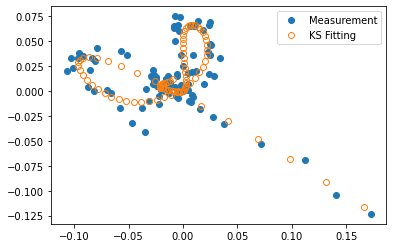

In [80]:
idx = 144
fig, ax = plt.subplots()
test_t, test_traj, _ = extract_agt_data(file_path_list[idx], origin_num_points_in_traj, num_points_in_traj)
ax.plot(test_traj[:,0], test_traj[:,1], 'o', label = 'Measurement')
ax.plot(posterior_means[idx,:, 0], posterior_means[idx,:,3], 'o', fillstyle = 'none', label = 'KS Fitting')
ax.legend()

In [79]:
test_t

array([0.        , 0.10001   , 0.2       , 0.30002001, 0.40000999,
       0.5       , 0.60001999, 0.69999999, 0.79999   , 0.89997   ,
       0.99996001, 1.09993994, 1.19992995, 1.29990995, 1.39989996,
       1.49986994, 1.59985995, 1.69984996, 1.79982996, 1.89980996,
       1.99979997, 2.0997901 , 2.19977999, 2.29978991, 2.39982009,
       2.49984002, 2.59982991, 2.6998601 , 2.79984999, 2.8998301 ,
       2.99985003, 3.09983993, 3.19981003, 3.29979992, 3.39978004,
       3.49976993, 3.59978008, 3.69981003, 3.79982996, 3.89982009,
       3.99984002, 4.0998702 , 4.19988012, 4.29990005, 4.39991999,
       4.49990988, 4.59989023, 4.69992018, 4.79990005, 4.89989996,
       4.99987984, 5.0998702 , 5.19989014, 5.29988003, 5.39988995,
       5.49986982, 5.59986019, 5.69988012, 5.79987001, 5.89988995,
       5.99987984, 6.0998702 , 6.1998601 , 6.29983997, 6.39984989,
       6.49986982, 6.59986019, 6.69987011, 6.79984999, 6.89987993,
       6.99989986, 7.09988022, 7.19991016, 7.29988003, 7.39986

In [75]:
test_traj[:, [2,3]]

array([[ 1.46942139e+00,  3.90625000e-01],
       [ 1.46942139e+00,  3.90625000e-01],
       [ 1.53939819e+01,  6.05468750e-01],
       [ 1.36019897e+01,  1.14257812e+00],
       [ 1.42404175e+01,  8.78906250e-01],
       [ 1.39047241e+01,  1.02539062e+00],
       [ 1.37860107e+01,  1.13281250e+00],
       [ 1.36227417e+01,  9.17968750e-01],
       [ 1.33099365e+01,  1.15234375e+00],
       [ 1.30319214e+01,  9.57031250e-01],
       [ 1.30807495e+01,  9.66796875e-01],
       [ 1.23669434e+01,  9.86328125e-01],
       [ 1.30996704e+01,  1.08398438e+00],
       [ 1.25074768e+01,  7.42187500e-01],
       [ 1.23010254e+01,  7.81250000e-01],
       [ 1.22206116e+01,  7.51953125e-01],
       [ 1.21571350e+01,  8.30078125e-01],
       [ 1.18519592e+01,  5.95703125e-01],
       [ 1.17785645e+01,  6.93359375e-01],
       [ 1.12329102e+01,  5.85937500e-01],
       [ 1.12976074e+01,  4.58984375e-01],
       [ 1.11827087e+01,  4.98046875e-01],
       [ 1.09686279e+01,  4.39453125e-01],
       [ 1.